In [14]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import copy
import json
%matplotlib inline

from deeppavlov.core.commands.utils import set_deeppavlov_root, expand_path
from deeppavlov.models.evolution.evolution_param_generator import ParamsEvolution

2018-06-25 14:31:29.12 DEBUG in 'matplotlib.backends'['__init__'] at line 90: backend module://ipykernel.pylab.backend_inline version unknown


## Set here path to your config file, key main model and population size

In [34]:
CONFIG_FILE = "../../configs/evolution/evolve_intents_snips.json"
KEY_MAIN_MODEL = "main"
POPULATION_SIZE = 2
    
with open(CONFIG_FILE, "r") as f:
    basic_params = json.load(f)

set_deeppavlov_root(basic_params)
print("Considered basic config:\n{}".format(json.dumps(basic_params, indent=2)))

Considered basic config:
{
  "dataset_reader": {
    "name": "basic_classification_reader",
    "x": "text",
    "y": "intents",
    "data_path": "snips"
  },
  "dataset_iterator": {
    "name": "basic_classification_iterator",
    "seed": {
      "evolve_range": [
        50,
        500
      ],
      "discrete": true
    },
    "field_to_split": "train",
    "split_fields": [
      "train",
      "valid"
    ],
    "split_proportions": [
      0.9,
      0.1
    ]
  },
  "chainer": {
    "in": [
      "x"
    ],
    "in_y": [
      "y"
    ],
    "pipe": [
      {
        "id": "classes_vocab",
        "name": "default_vocab",
        "fit_on": [
          "y"
        ],
        "level": "token",
        "save_path": "vocabs/snips_classes.dict",
        "load_path": "vocabs/snips_classes.dict"
      },
      {
        "in": [
          "x"
        ],
        "out": [
          "x_lower"
        ],
        "name": "str_lower"
      },
      {
        "id": "my_embedder",
        "nam

In [37]:
evolution = ParamsEvolution(population_size=POPULATION_SIZE,
                            key_main_model=KEY_MAIN_MODEL,
                            **basic_params)

validate_best = evolution.get_value_from_config(
    evolution.basic_config, list(evolution.find_model_path(
        evolution.basic_config, "validate_best"))[0] + ["validate_best"])
test_best = evolution.get_value_from_config(
    evolution.basic_config, list(evolution.find_model_path(
        evolution.basic_config, "test_best"))[0] + ["test_best"])

TITLE = str(Path(evolution.get_value_from_config(
    evolution.basic_config, evolution.main_model_path + ["save_path"])).stem)
print("Title name for the considered evolution is `{}`.".format(TITLE))

data = pd.read_csv(str(expand_path(Path(evolution.get_value_from_config(
    evolution.basic_config, evolution.main_model_path + ["save_path"])).joinpath(
    "result_table.csv"))), sep='\t')
print("Number of populations: {}.".format(int(data.shape[0] / POPULATION_SIZE)))
data.fillna(0., inplace=True)

2018-06-25 14:52:07.93 INFO in 'deeppavlov.models.evolution.evolution_param_generator'['evolution_param_generator'] at line 55: Main model path in config: ['chainer', 'pipe', 4]


Title name for the considered evolution is `intents_snips`.
Number of populations: 2.


In [43]:
MEASURES = evolution.get_value_from_config(
    evolution.basic_config, list(evolution.find_model_path(
        evolution.basic_config, "metrics"))[0] + ["metrics"])

for measure in MEASURES:
    print("\nMeasure: {}".format(measure))
    for data_type in ["valid", "test"]:
        print("{}:".format(data_type))
        argmin = data[measure + "_" + data_type].argmin()
        argmax = data[measure + "_" + data_type].argmax()
        print("min for\t{} model on\t{} population".format(argmin % POPULATION_SIZE,
                                                             argmin // POPULATION_SIZE))
        print("max for\t{} model on\t{} population".format(argmax % POPULATION_SIZE,
                                                             argmax // POPULATION_SIZE))


Measure: classification_accuracy
valid:
min for	0 model on	0 population
max for	0 model on	1 population
test:
min for	0 model on	0 population
max for	0 model on	0 population

Measure: classification_f1
valid:
min for	0 model on	0 population
max for	1 model on	1 population
test:
min for	0 model on	0 population
max for	0 model on	0 population

Measure: classification_roc_auc
valid:
min for	1 model on	0 population
max for	0 model on	0 population
test:
min for	0 model on	0 population
max for	0 model on	0 population


/home/dilyara/anaconda3/envs/deep36/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  if __name__ == '__main__':
/home/dilyara/anaconda3/envs/deep36/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  # Remove the CWD from sys.path while we load stuff.


## If you want to plot measures depending on population colored by evolved measure value

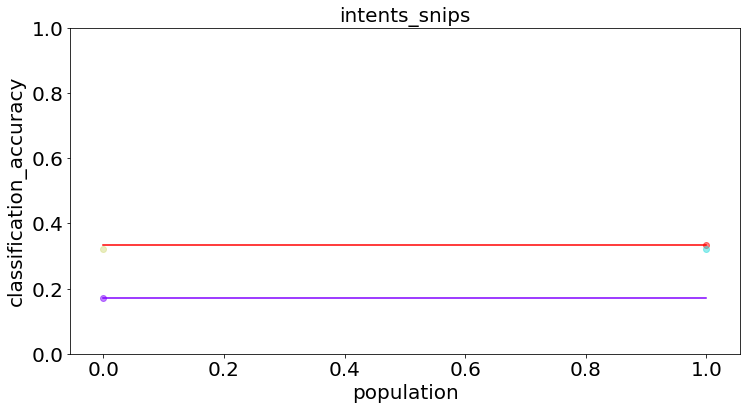

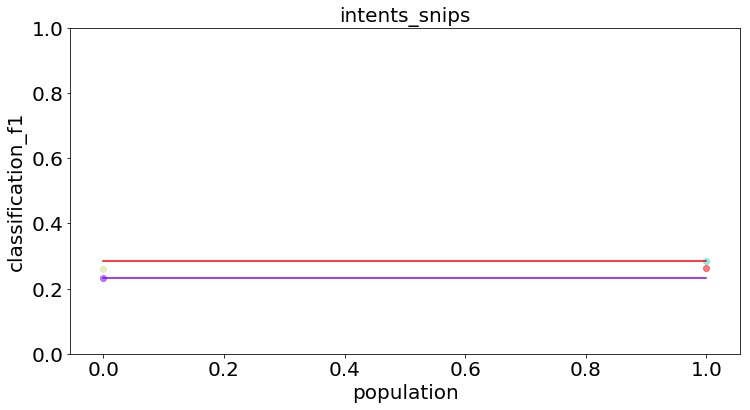

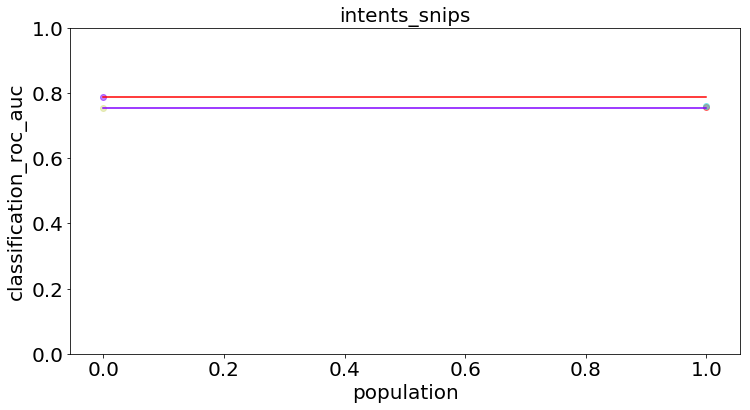

In [50]:
path_to_pics = expand_path(Path(evolution.get_value_from_config(
    evolution.basic_config, evolution.main_model_path + ["save_path"])).joinpath("pics"))
path_to_pics.mkdir(exist_ok=True, parents=True)

if validate_best:
    evolve_metric = MEASURES[0] + "_valid"
elif test_best:
    evolve_metric = MEASURES[0] + "_test"
    
cmap = plt.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, data.shape[0])]
color_ids = np.argsort(data.loc[:, evolve_metric].values)

ylims = [(0., 1)] * len(MEASURES)

for metric, ylim in zip(MEASURES, ylims):
    plt.figure(figsize=(12,6))
    if validate_best:
        for i in range(data.shape[0]):
            plt.scatter(i // POPULATION_SIZE, 
                        data.loc[:, metric + "_valid"].values[i], 
                        c=colors[np.where(color_ids == i)[0][0]], alpha=0.5, marker='o')
        plt.plot(np.arange(data.shape[0]//POPULATION_SIZE), 
             data.loc[:, metric + "_valid"].max() * np.ones(data.shape[0]//POPULATION_SIZE), 
             c=colors[-1])
        plt.plot(np.arange(data.shape[0]//POPULATION_SIZE), 
             data.loc[:, metric + "_valid"].min() * np.ones(data.shape[0]//POPULATION_SIZE), 
             c=colors[0])
    if test_best:
        for i in range(data.shape[0]):
            plt.scatter(i // POPULATION_SIZE, 
                        data.loc[:, metric + "_test"].values[i], 
                        c=colors[np.where(color_ids == i)[0][0]], alpha=0.5, marker='+', s=200)
        plt.plot(np.arange(data.shape[0]//POPULATION_SIZE), 
             data.loc[:, metric + "_test"].max() * np.ones(data.shape[0]//POPULATION_SIZE), "--",
             c=colors[-1])
        plt.plot(np.arange(data.shape[0]//POPULATION_SIZE), 
             data.loc[:, metric + "_test"].min() * np.ones(data.shape[0]//POPULATION_SIZE), "--",
             c=colors[0])
    

    plt.ylabel(metric, fontsize=20)
    plt.xlabel("population", fontsize=20)
    plt.title(TITLE, fontsize=20)
    plt.ylim(ylim[0], ylim[1])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.savefig(path_to_pics.joinpath(y_label + ".png"))
    plt.show()

## If you want to plot measures depending on population colored by `evolution_model_id`

In [57]:
params_dictionaries = []

for i in range(data.shape[0]):
    data.loc[i, "params"] = data.loc[i, "params"].replace("False", "false")
    data.loc[i, "params"] = data.loc[i, "params"].replace("True", "true")
    json_acceptable_string = data.loc[i, "params"].replace("'", "\"")
    d = json.loads(json_acceptable_string)
    params_dictionaries.append(d)

models_ids = []
for pdict in params_dictionaries:
    models_ids.append(pdict["evolution_model_id"])
    
models_ids = np.array(models_ids)
models_ids

array([1, 1, 2, 2])

In [63]:
np.unique(models_ids)

array([1, 2])

In [71]:
np.where(models_ids[2] == np.unique(models_ids))[0][0]

1

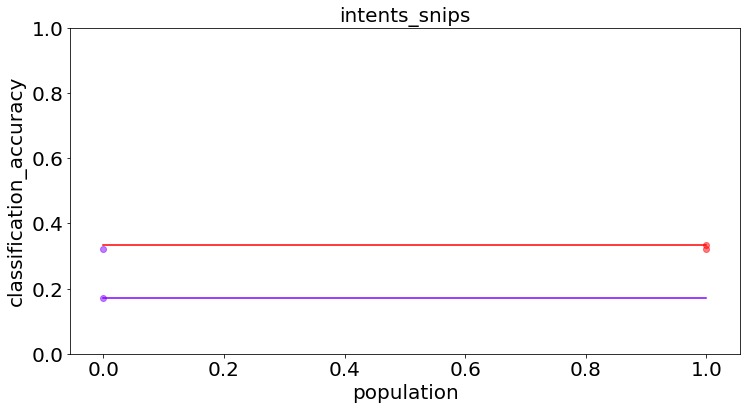

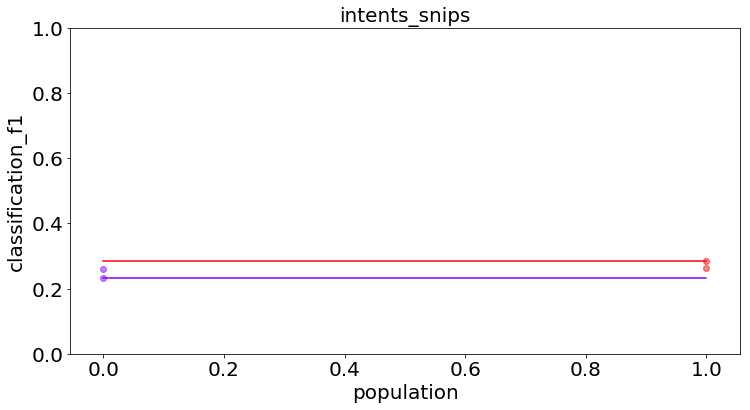

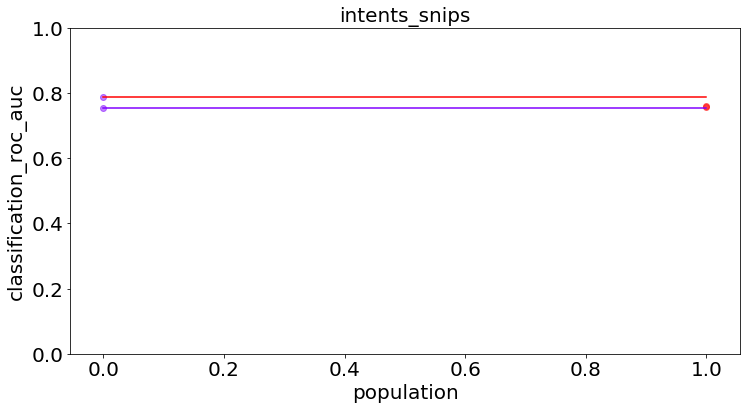

In [73]:
cmap = plt.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, len(np.unique(models_ids)))]

ylims = [(0., 1)] * len(MEASURES)

for metric, ylim in zip(MEASURES, ylims):
    plt.figure(figsize=(12,6))
    if validate_best:
        for i in range(data.shape[0]):
            plt.scatter(i // POPULATION_SIZE, 
                        data.loc[:, metric + "_valid"].values[i], 
#                         c=colors[models_ids[i]], alpha=0.5, marker='o')
                        c=colors[np.where(models_ids[i] == np.unique(models_ids))[0][0]], alpha=0.5, marker='o')
            
        plt.plot(np.arange(data.shape[0]//POPULATION_SIZE), 
             data.loc[:, metric + "_valid"].max() * np.ones(data.shape[0]//POPULATION_SIZE), 
             c=colors[-1])
        plt.plot(np.arange(data.shape[0]//POPULATION_SIZE), 
             data.loc[:, metric + "_valid"].min() * np.ones(data.shape[0]//POPULATION_SIZE), 
             c=colors[0])
    if test_best:
        for i in range(data.shape[0]):
            plt.scatter(i // POPULATION_SIZE, 
                        data.loc[:, metric + "_test"].values[i], 
                        c=colors[np.where(models_ids[i] == np.unique(models_ids))[0][0]], alpha=0.5, marker='+', s=200)
        plt.plot(np.arange(data.shape[0]//POPULATION_SIZE), 
             data.loc[:, metric + "_test"].max() * np.ones(data.shape[0]//POPULATION_SIZE), "--",
             c=colors[-1])
        plt.plot(np.arange(data.shape[0]//POPULATION_SIZE), 
             data.loc[:, metric + "_test"].min() * np.ones(data.shape[0]//POPULATION_SIZE), "--",
             c=colors[0])
    

    plt.ylabel(metric, fontsize=20)
    plt.xlabel("population", fontsize=20)
    plt.title(TITLE, fontsize=20)
    plt.ylim(ylim[0], ylim[1])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.savefig(path_to_pics.joinpath(y_label + "_colored_ids.png"))
    plt.show()
